In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc
%matplotlib inline

The source for this notebook is: http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/

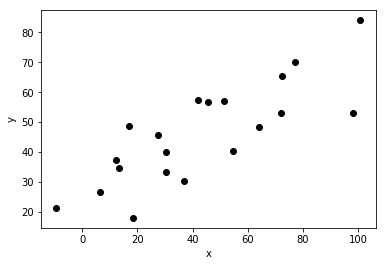

In [2]:

np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)


plt.plot(xdata, ydata, 'ok')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    
    
def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)

 [-----------------100%-----------------] 100000 of 100000 complete in 17.3 sec

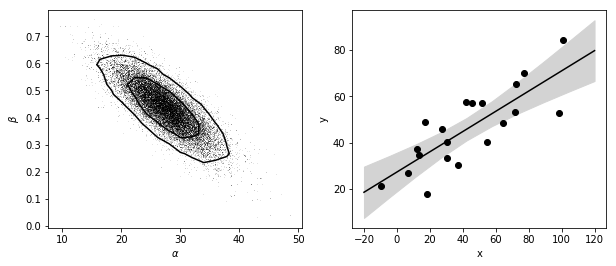

In [12]:
alpha = pymc.Uniform('alpha', -100, 100)

@pymc.stochastic(observed=False)
def beta(value=0):
    return -1.5 * np.log(1 + value ** 2)

@pymc.stochastic(observed=False)
def sigma(value=1):
    return -np.log(abs(value))

# Define the form of the model and likelihood
@pymc.deterministic
def y_model(x=xdata, alpha=alpha, beta=beta):
    return alpha + beta * x

y = pymc.Normal('y', mu=y_model, tau=1. / sigma ** 2, observed=True, value=ydata)

# package the full model in a dictionary
model1 = dict(alpha=alpha, beta=beta, sigma=sigma, y_model=y_model, y=y)


# run the basic MCMC: we'll do 100000 iterations to match emcee above
S = pymc.MCMC(model1)
S.sample(iter=100000, burn=50000)
# extract the traces and plot the results
pymc_trace = [S.trace('alpha')[:],
              S.trace('beta')[:],
              S.trace('sigma')[:]]

plot_MCMC_results(xdata, ydata, pymc_trace)


Now let's perform a 'typical' linear regression.

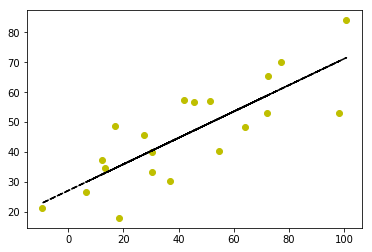

In [16]:
fit = np.polyfit(xdata, ydata,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(xdata, ydata, 'yo', xdata, fit_fn(xdata), '--k')

